## Notebook #4: Insights and Visualizations

In this notebook, I will explore why my model works and what my recommendations are. I will run through validating regression assumptions for my model and visualizing my results. I will explain why I made the decisions I made, including why I ended up keeping so many features even though they were negative or zeroed out. I will explain these things as I go and will summarize my findings at the end, including a section for recommendations and future improvements to this project.

Unfortunately, I have to input my model again into this notebook in order to use my visualizations correctly. I will do that below this line. Please head to  [ASSUMPTIONS CHECK AND VISUALIZATIONS](#ASSUMPTIONS_CHECK_AND_VISUALIZATIONS) to skip directly to coefficient analysis. 

---

In [1]:
# All packages at the top

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LassoCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
df_house = pd.read_csv('./datasets/train.csv')
pd.set_option('display.max_columns', None)
df_house.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


In [6]:
df_house.columns = df_house.columns.str.lower().str.replace(' ', '_')

In [7]:
df_house.drop(columns=['pid'], inplace=True)

In [8]:
df_house = df_house[df_house['gr_liv_area'] < 4000]  # Making sure I remove those outliers

In [9]:
df_nums = df_house.select_dtypes(include=[np.number])
df_nums.head(3)

,id,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice
0,109,60,NaN,13517,6,8,1976,2005,289.0,533.0,0.0,192.0,725.0,725,754,0,1479,0.0,0.0,2,1,3,1,6,0,1976.0,2.0,475.0,0,44,0,0,0,0,0,3,2010,130500
1,544,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0,276.0,913.0,913,1209,0,2122,1.0,0.0,2,1,4,1,8,1,1997.0,2.0,559.0,0,74,0,0,0,0,0,4,2009,220000
2,153,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0,326.0,1057.0,1057,0,0,1057,1.0,0.0,1,0,3,1,5,0,1953.0,1.0,246.0,0,52,0,0,0,0,0,1,2010,109000


In [10]:
df_house.select_dtypes(include=[np.object_]).head(3)

,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating,heating_qc,central_air,electrical,kitchen_qual,functional,fireplace_qu,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,pool_qc,fence,misc_feature,sale_type
0,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,Gable,CompShg,HdBoard,Plywood,BrkFace,Gd,TA,CBlock,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
1,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD
2,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,Gd,CBlock,TA,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,Gd,Typ,NaN,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD


In [11]:
df_cat = df_house[['id', 
                   'utilities', 
                   'neighborhood', 
                   'bldg_type', 
                   'house_style', 
                   'roof_style', 
                   'mas_vnr_type', 
                   'exter_qual', 
                   'exter_cond', 
                   'foundation', 
                   'bsmt_qual', 
                   'bsmt_cond', 
                   'kitchen_qual', 
                   'functional', 
                   'garage_type', 
                   'garage_finish', 
                   'garage_qual', 
                   'garage_cond', 
                   'paved_drive', 
                   'alley',
                   'fireplace_qu',
                   'pool_qc',
                   'fence',
                   'misc_feature'
                   ]]

In [12]:
df_cat.head(3)

,id,utilities,neighborhood,bldg_type,house_style,roof_style,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,kitchen_qual,functional,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,alley,fireplace_qu,pool_qc,fence,misc_feature
0,109,AllPub,Sawyer,1Fam,2Story,Gable,BrkFace,Gd,TA,CBlock,TA,TA,Gd,Typ,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,NaN,NaN
1,544,AllPub,SawyerW,1Fam,2Story,Gable,BrkFace,Gd,TA,PConc,Gd,TA,Gd,Typ,Attchd,RFn,TA,TA,Y,NaN,TA,NaN,NaN,NaN
2,153,AllPub,NAmes,1Fam,1Story,Gable,None,TA,Gd,CBlock,TA,TA,Gd,Typ,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,NaN,NaN


In [13]:
df_combined = pd.merge(left = df_nums, right = df_cat, how = 'inner')

In [14]:
X = df_combined.drop(columns=['id', 'saleprice'])
y = df_combined['saleprice']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [15]:
ohe = OneHotEncoder(handle_unknown='ignore')
smart_encoder = make_column_transformer((ohe, ['overall_qual',   # Again here, I had to manually input these 
                                               'utilities', 
                                               'neighborhood', 
                                               'bldg_type', 
                                               'house_style', 
                                               'roof_style', 
                                               'mas_vnr_type', 
                                               'exter_qual', 
                                               'exter_cond', 
                                               'foundation', 
                                               'bsmt_qual', 
                                               'bsmt_cond', 
                                               'kitchen_qual', 
                                               'functional', 
                                               'garage_type', 
                                               'garage_finish', 
                                               'garage_qual', 
                                               'garage_cond', 
                                               'paved_drive',
                                               'alley',
                                               'fireplace_qu',
                                               'pool_qc',
                                               'fence',
                                               'misc_feature']),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False)

X_train_enc = smart_encoder.fit_transform(X_train)
X_val_enc = smart_encoder.transform(X_val)

In [16]:
X_train_enc = pd.DataFrame(X_train_enc, columns = smart_encoder.get_feature_names_out())
X_val_enc = pd.DataFrame(X_val_enc, columns = smart_encoder.get_feature_names_out())

In [17]:
si = SimpleImputer(strategy = 'constant', fill_value=0)

X_train_fill = si.fit_transform(X_train_enc)
X_val_fill = si.transform(X_val_enc)

In [18]:
X_train_fill = pd.DataFrame(X_train_fill, columns = si.feature_names_in_)
X_val_fill = pd.DataFrame(X_val_fill, columns = si.feature_names_in_)

In [19]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train_fill)
X_val_sc = ss.transform(X_val_fill)

X_train_sc = pd.DataFrame(X_train_sc, columns = ss.get_feature_names_out())
X_val_sc = pd.DataFrame(X_val_sc, columns = ss.get_feature_names_out())

In [20]:
lasso_cv = LassoCV(cv = 10).fit(X_train_sc, y_train) 

print('best alpha:', lasso_cv.alpha_)
print('score:', lasso_cv.score(X_train_sc, y_train))

best alpha: 567.9607901002692
score: 0.9279680118839857


In [21]:
lasso_cv.score(X_val_sc, y_val)

0.9344318425844886

In [22]:
tt = TransformedTargetRegressor(regressor = lasso_cv, func = np.log, inverse_func = np.exp)

In [23]:
tt.fit(X_train_sc, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LassoCV(cv=10))

In [24]:
tt.score(X_train_sc, y_train)

0.9424373847158217

In [25]:
tt.score(X_val_sc, y_val)

0.9376050739263987

In [26]:
y_train_preds = tt.predict(X_train_sc)

In [27]:
mean_squared_error(y_train, y_train_preds)

361050075.80118006

In [28]:
(mean_squared_error(y_train, y_train_preds))**0.5

19001.317738545928

In [29]:
y_val_preds = tt.predict(X_val_sc)
mean_squared_error(y_val, y_val_preds)

394467870.71098816

In [30]:
(mean_squared_error(y_val, y_val_preds))**0.5

19861.21523751727

In [31]:
y_train_look = list(zip(y_train, y_train_preds))

In [32]:
y_val_look = list(zip(y_val, y_val_preds))

In [33]:
mean_absolute_error(y_train, y_train_preds), mean_absolute_error(y_val, y_val_preds)

(12902.615440200454, 13425.913183469822)

---

**ASSUMPTIONS CHECK AND VISUALIZATIONS:**

<a id='#ASSUMPTIONS_CHECK_AND_VISUALIZATIONS'></a> 

Within the same section, I will explore my assumptions and produce some visualizations to help relay my recommendations. I will walk through each assumption and include why I believe they have each been met. 

In [39]:
residuals = y_train - y_train_preds

In [40]:
residuals

415     -7920.833340
273     -9090.913201
1146   -29893.853708
250     -2298.933127
413       233.013119
            ...     
1724    -6259.284831
1095    -6019.165313
1130   -10846.929276
1294     1251.191150
860     14668.486316
Name: saleprice, Length: 1536, dtype: float64

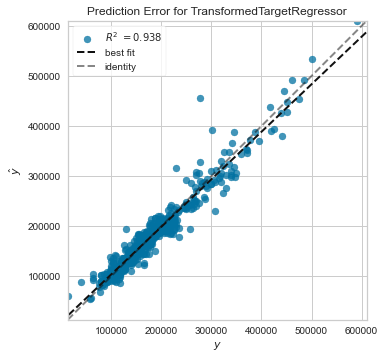

In [45]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import prediction_error

visualizer = prediction_error(tt, X_train_sc, y_train, X_val_sc, y_val);

Looking at this residuals plot, we can see the assumption of linearity has been met. The plotted values line up well along the best fit line. There are a couple odd data points, but no significant outliers.

The next assumption can be explained verbally instead of visually. The dataset has independence. It is not time series data and one home sale does not depend on another home sale necessarily. Not all those who sell a home then go buy a home, even though maybe most do. 

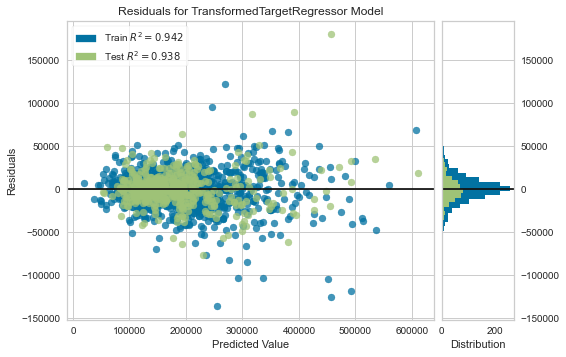

In [42]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(tt)

visualizer.fit(X_train_sc, y_train)  
visualizer.score(X_val_sc, y_val)  
visualizer.show()  ;

# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

This beautiful residuals plot shows our next two assumptions. 

As we can see from the distribution on the right, the residuals have a normal distribution. 

The hardest assumption to meet is equal variances. While the plot of my residuals is definitely not perfectly scattered and has a slight horn shape, I believe the assumption is met because it is a very wide horn shape. Further, considering all other metrics score well and assumptions are met, I can find this plot acceptable.

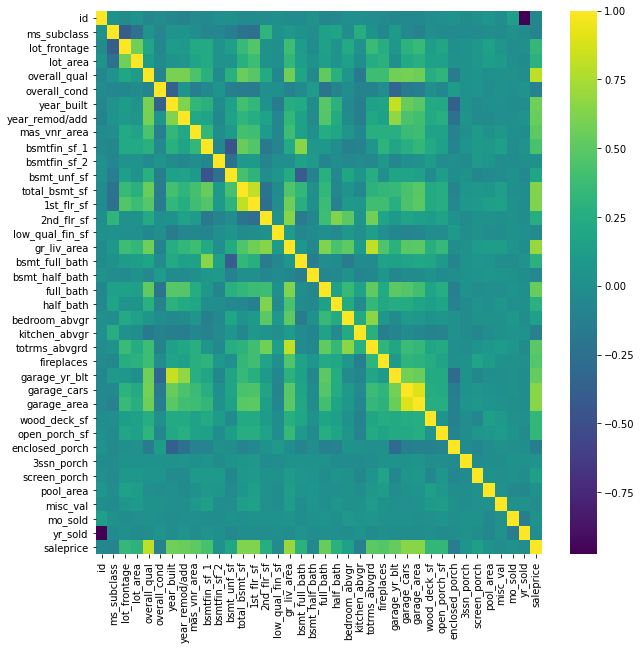

In [439]:
plt.figure(figsize=(10,10))   
sns.heatmap(df_house.corr(), cmap='viridis');

Finally, we have multicolinearity. For reference, I included here the heatmap from the first notebook exploring the relationships between our numeric values. As we can see, there are some multicolinear relationships here, albeit I would argue majority are in the none-mild correlation category. To correct for this, I ran the model through a LassoCV regularization which accounts for many features that may have some multicolinearity. Therefore, I can say this assumption is met.

---

**COEFFICIENTS AND IMPORTANT FEATURES:**

Considering my problem, I wanted to maintain as many features as possible while still churning out an effective model. Therefore, I have 185 coefficients to match my 185 features. This means that making inferences about them would be quite difficult. To make this process smoother, I will analyze them within 3 categories: the top group of positive coefficients, all those that equal 0 (AKA non-influential features), and the worst of the worst coefficients. They are as follows:

In [34]:
col_coefs = lasso_cv.coef_

In [35]:
zipped = list(zip(X_train_sc.columns, col_coefs))

In [ ]:
zipped # run this cell to view list 

In [ ]:
[col for col,coef in zipped if coef > 3000] # run this cell to view list 

As I look at my best features, I must say that I am not much surprised. All of these features logically make sense to me, which is great as it tells me my model works with real-life situations. Here are some examples of interpretations of these high positive coefficients: 
* Holding all else constant, as lot area and above ground living area increase separately by one square foot, the home sale price could increase by $\$5,488$ and $\$25,660$, respectively. This number for the square feet of living area surprises me greatly, especially because I even removed the major outliers from the data. 

* As the year built 'increases' or gets closer to the current year, the predicted sale price increases by $\$11,886$. In other words, newer houses cost more than older houses. 

* Compared to other neighborhoods in Ames, Northridge Heights and Stone Brook are the best predictors of increasing sale price with coefficients of $\$3,123$ and $\$4,407$, respectively.

* Holding all else constant, as the square footage of a screen porch increases by one square foot, the price of the home could increase by $\$3,148$.

* Homes with excellent quality of almost anything - exterior, basement, kitchen, and overall - have higher sale prices compared to homes that have numbers less than excellent (for overall, 9-10 are designated as excellent). 

* As the overall quality of the home increases by 1 unit of quality, the price could increase by thousands of dollars holding all else constant. The best predictor within overall quality is a quality level of 9. Holding all else constant, houses with a quality level of 9, could have a prise increase by $\$9,717$ (these quality units are undefined both in the data description and in the paper the professor wrote about the data ([*Paper*](http://jse.amstat.org/v19n3/decock.pdf), [*Description*](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))).

In [ ]:
[col for col,coef in zipped if coef == 0] # run this cell to view list 

For this category (coefficient equals zero), there are a very surprising amount of features. There are so many that I tried to remove these features from my model and run it again, but it didn't change anything (I'm assuming because LassoCV already penalizes them to zero making them irrelevant anyways). Here are some examples of interpretations of these coefficients: 

* Holding all else constant, the quality of fireplaces, garages, or basements make no change on home sale price. Further, it doesn't matter if the house has access to an alley - there is no predicted change in house sale price. 

* Out of 28 neighborhoods, homes in 16 of them have no better or worse sale price than other neighborhoods. 

* If the home has a pool, for every square foot in size that it increases, the home sale price will not change. This means that if a house has a pool, it does not matter what size it is in terms of sale price. 

* For each month in the year, there are no significant changes in sale price from one to the other, holding all else constant. This means that the physical features of the home may be more influential for sale price than the time of year it is sold.

In [ ]:
[col for col,coef in zipped if coef < -1000] # run this cell to view list 

There are less negative coefficients than positive coefficients, but some of them are more surprising than others. Here are some interpretations: 

* A foundation of cinderblock compared to other foundation types can decrease home sale price by $\$1,467$ holding all else constant.

* A roof style of Mansard compared to other roof types can decrease home sale price by $\$1,435$ holding all else constant. For reference, this is what a Mansard roof looks like, which - for the record - is not surprising that it decreases home price in my opinion. 

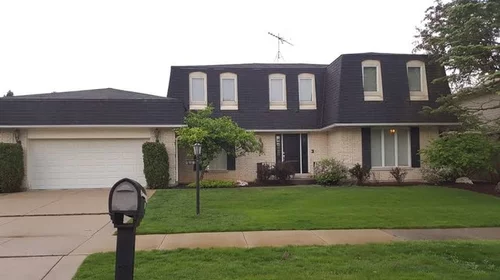

[*Source*](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.houzz.com%2Fdiscussions%2F4655340%2Flooking-to-update-mansard-roof-home&psig=AOvVaw16IwFA9s1dOwYwBxodrOUj&ust=1650329707724000&source=images&cd=vfe&ved=0CAwQjRxqFwoTCLCC9baznPcCFQAAAAAdAAAAABAD)

* As the number of bedrooms and kitchens in the home increases, the predicted sale price can fall. This one is confusing for me, as I would assume that houses with more bedrooms would be therefore larger and then therefore cost more. However, I theorize that this increase in kitchens and bedrooms may signify a housing type different than single family (which has a positive coefficient) - maybe the home is a duplex, townhome, or multi-family home (which have non-influential and negative coefficients).

---

**MORE VISUALIZATIONS:**

In this section, I will create visualizations for the coefficients to portray the best and worst features in my model.

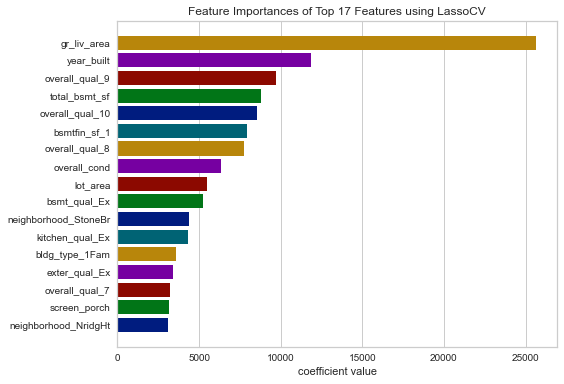

In [187]:
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(lasso_cv, relative=False, topn=17, colormap='sns_dark')
viz.fit(X_train_sc, y_train)
viz.show('feature_importance.jpg');

In [134]:
lows = [col for col,coef in zipped if coef < -1000]

In [167]:
lows_c = [round(coef,2) for col,coef in zipped if coef < -1000]

In [168]:
list(zip(lows, lows_c))

[('roof_style_Mansard', -1435.07),
 ('exter_qual_TA', -2357.28),
 ('foundation_CBlock', -1467.36),
 ('kitchen_qual_TA', -1312.13),
 ('functional_Maj1', -1869.41),
 ('functional_Sal', -1022.75),
 ('bedroom_abvgr', -2122.17),
 ('kitchen_abvgr', -1240.14)]

In [159]:
df_lows = pd.DataFrame(lows_c, lows, columns = ['coef'])

In [172]:
df_lows['coef'] = df_lows['coef'].sort_values(ascending=True)

In [173]:
df_lows

,coef
roof_style_Mansard,-1435.07
exter_qual_TA,-2357.28
foundation_CBlock,-1467.36
kitchen_qual_TA,-1312.13
functional_Maj1,-1869.41
functional_Sal,-1022.75
bedroom_abvgr,-2122.17
kitchen_abvgr,-1240.14


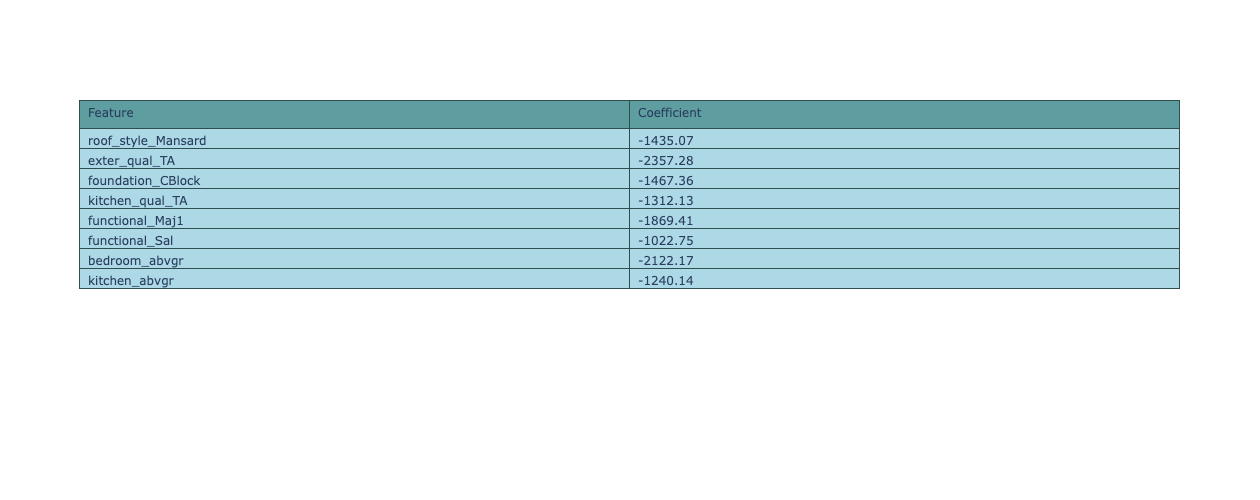

In [186]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    header=dict(values=['Feature', 'Coefficient'],
                line_color='darkslategray',
                fill_color='cadetblue',
                align='left'),
    cells=dict(values=[df_lows.index, # 1st column
                       df_lows.coef], # 2nd column
               line_color='darkslategray',
               fill_color='lightblue',
               align='left'))
])

fig.update_layout(width=500, height=500)
fig.show()

# https://plotly.com/python/table/

To share some predictions from our insights (and to provide meaningful examples to the group), let's look at two different homes and their predicted sale price based on their features.

In [188]:
df_test = pd.read_csv('./datasets/test.csv')

df_test.columns = df_test.columns.str.lower().str.replace(' ', '_')

test_id = df_test['id']

df_test.drop(columns=['pid'], inplace=True)

df_nums_test = df_test.select_dtypes(include=[np.number])
df_cat_test = df_test[['id', 
                   'utilities', 
                   'neighborhood', 
                   'bldg_type', 
                   'house_style', 
                   'roof_style', 
                   'mas_vnr_type', 
                   'exter_qual', 
                   'exter_cond', 
                   'foundation', 
                   'bsmt_qual', 
                   'bsmt_cond', 
                   'kitchen_qual', 
                   'functional', 
                   'garage_type', 
                   'garage_finish', 
                   'garage_qual', 
                   'garage_cond', 
                   'paved_drive', 
                   'alley',
                   'fireplace_qu',
                   'pool_qc',
                   'fence',
                   'misc_feature'
                   ]]
df_combined_test = pd.merge(left = df_nums_test, right = df_cat_test, how = 'inner')

X = df_combined_test.drop(columns=['id'])

In [189]:
df_test.shape

(878, 79)

In [190]:
df_test.shape

(878, 79)

In [191]:
X.head(3)

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,utilities,neighborhood,bldg_type,house_style,roof_style,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,kitchen_qual,functional,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,alley,fireplace_qu,pool_qc,fence,misc_feature
0,190,69.0,9142,6,8,1910,1950,0.0,0,0,1020,1020,908,1020,0,1928,0,0,2,0,4,2,9,0,1910.0,1,440,0,60,112,0,0,0,0,4,2006,AllPub,OldTown,2fmCon,2Story,Gable,None,TA,Fa,Stone,Fa,TA,Fa,Typ,Detchd,Unf,Po,Po,Y,Grvl,NaN,NaN,NaN,NaN
1,90,NaN,9662,5,4,1977,1977,0.0,0,0,1967,1967,1967,0,0,1967,0,0,2,0,6,2,10,0,1977.0,2,580,170,0,0,0,0,0,0,8,2006,AllPub,Sawyer,Duplex,1Story,Gable,None,TA,TA,CBlock,Gd,TA,TA,Typ,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,NaN,NaN
2,60,58.0,17104,7,5,2006,2006,0.0,554,0,100,654,664,832,0,1496,1,0,2,1,3,1,7,1,2006.0,2,426,100,24,0,0,0,0,0,9,2006,AllPub,Gilbert,1Fam,2Story,Gable,None,Gd,TA,PConc,Gd,Gd,Gd,Typ,Attchd,RFn,TA,TA,Y,NaN,Gd,NaN,NaN,NaN


In [192]:
X_enc = smart_encoder.transform(X)

X_enc = pd.DataFrame(X_enc, columns = smart_encoder.get_feature_names_out())

In [193]:
X_fill = si.transform(X_enc)

X_fill = pd.DataFrame(X_fill, columns = si.feature_names_in_)

In [194]:
X_sc = ss.transform(X_fill)

X_sc = pd.DataFrame(X_sc, columns = ss.get_feature_names_out())

In [195]:
preds = tt.predict(X_sc)

In [197]:
X_sc.shape

(878, 185)

In [198]:
df_test['saleprice'] = preds

In [201]:
np.random.randint(0, 878)

776

In [212]:
np.random.randint(0, 878)

514

In [214]:
df_test.iloc[[776]]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
776,1579,60,RL,81.0,12018,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,2Story,7,5,2008,2008,Gable,CompShg,VinylSd,VinylSd,Stone,60.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,796,796,GasA,Ex,Y,SBrkr,796,816,0,1612,0,0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2008.0,Fin,3,666,TA,TA,Y,0,64,0,0,0,0,NaN,NaN,NaN,0,10,2008,New,200483.142824


In [215]:
df_test.iloc[[514]]

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
514,1303,20,RM,62.0,7311,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,5,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,BrkTil,TA,TA,No,Unf,0,Unf,0,407,407,GasA,TA,N,FuseA,407,0,0,407,0,0,1,0,1,1,TA,3,Typ,0,NaN,Detchd,1949.0,Unf,1,297,Fa,TA,Y,76,0,120,0,0,0,NaN,NaN,NaN,0,3,2008,WD,59801.651198


Our first example is house sale ID 1579. This home has a lot area of 12018, is in the Timber neighborhood, is a single family home, overall quality of 7, built in 2008, finished basement square footage of 796, total above ground square footage of 1612, and sold in 2008 as a new home. It's predicted sale price would be $\$200,483.14$.

Our second example is house sale ID 1303. This home has a lot area of 7311, is in the Old Town neighborhood, a single family home, overall quality of a 2, built in 1946, total finished basement square footage of 407, total above ground square footage of 407, and was sold in 2008 as a normal sale. It has a predicted price of $\$59,801.65$.

Based on the analysis of our model above, we can look at both of these examples with clarity. The price on the first home makes sense according to our model. The large lot area of the home and the total above ground square footage are the big sellers here according to our coefficients. Further, it was built in 2008 making it brand new when this data was collected. Finally, the finished basement square footage of 796 is high and very valuable. We could predict the house would sell for over two hundred thousand. For the second example, we see a significant decrease in predicted price. The kickers here are that the home is old, has a very low overall quality, a smaller above ground square footage and total finished basement square footage. All of these factors together, we can confidently predict a price of only around fifty thousand.

Even if our clients fall into the category of the second home, we can use this information to give our clients both an encouraging look at their potential sell value, and a realistic view of what may happen once their home is on the market.

---

**RECOMMENDATIONS AND FUTURE IMPROVEMENTS:**

According to this model and data, I have several recommendations. To answer our problem statement, we should use our insights to inform our decisions and clients to choose the best listing price for their home. 

If we have a client that lives in the Northbridge Heights or Stone Brook neighborhoods and have a large square footage home, we can predict their house will sell for more money than a client whose house is in another neighborhood or is of a much smaller size. We can use these insights to inform our listing prices for our clients. Our problem was that we wanted to provide more accurate listing prices for our clients trying to sell their homes. I believe the insights learned here can help us get our clients more return for their house sale, and ultimately, more return for our realtor percentage. Other important insights we can help our clients with is that if, for example, they are in a neighborhood that is not Northbridge Heights or Stone Brook, their house may not be currently priced for as much money even if it is of similar quality. However, if they were to finish their basement or screen their porch, their house could potentially sell for much more. These are the ways we can use this data to help our clients. 

Further, if we look inwards, we can direct our marketing strategies to the neighborhoods, or home sizes, or features that sell for higher prices.

In a future model, I would like to build several models based on a smaller range of features. I would target categories of data. For example, I would put all square footage related features in one model, all exterior related features in another. I believe this may give us a more pinpointed look at specific features or features that are related to other features. 